<a href="https://colab.research.google.com/github/mrezaim/Expanse/blob/main/EXPANSE_two_steps_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implimentation of verifying the effectiveness of two-step training method from EXPANSE.
The ideal is that similar to human education system, we may improve the accuracy and converegence time by first training the model on perfect data then finetune it on uncertain data.

Some parts of the following codes are imported (with and without adjustments) from "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/"

First we import all the necessary libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import gdown
import cv2
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from numpy import mean
from numpy import std
# to make the results of different run similar:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

Download and import Train and Test data from MNIST:

In [2]:
# Loading the MNIST dataset
#from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Visualize 9 samples of data from MNIST Train dataset:

3 8 7 9 9 0 1 1 5 

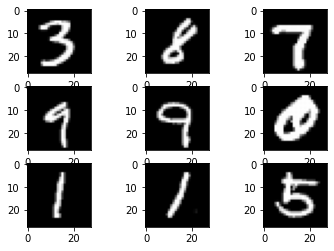

In [3]:
j=0
for i in range(10000,10009):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  print (trainy[i], end =" ")
plt.show()

Download the perfect samples pallet. It is a PNG file of 180 perfect samples (typed with different fonts).

In [4]:
url = 'https://drive.google.com/uc?id=1cnFUK7BvxjWFneIgGNA3sWlzoJNSXZHu&export=download'
output = 'perfect_digits.png'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1cnFUK7BvxjWFneIgGNA3sWlzoJNSXZHu&export=download
To: /content/perfect_digits.png
100%|██████████| 26.6k/26.6k [00:00<00:00, 14.1MB/s]


'perfect_digits.png'

Extracting 160 training samples and 20 testing samples from the perfect samples pallet and creatint train and test dataset by duplicate of samples. 

In [5]:
img_path = 'perfect_digits.png'
img = cv2.imread(img_path, 0)
#train_per_x = np.empty_like(trainX)
train_per_x = np.zeros(shape = ( 320, 28, 28 ), dtype=np.uint8)
train_per_y = np.zeros(shape = ( 320), dtype=np.uint8)
test_per_x = np.zeros(shape = ( 40, 28, 28 ), dtype=np.uint8)
test_per_y = np.zeros(shape = ( 40), dtype=np.uint8)
i=0
for v in range(2,18):
  for h in range(10):
    train_per_x[i] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i] = h
    train_per_x[i+160] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i+160] = h
    i += 1
i=0
for v in range(2):
  for h in range(10):
    test_per_x[i] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    test_per_y[i] = h
    test_per_x[i+20] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    test_per_y[i+20] = h
    i += 1
print('Perfect train dataset shape:', train_per_x.shape)
print('Perfect train label dataset shape:', train_per_y.shape)
print('Perfect test dataset shape:', test_per_x.shape)
print('Perfect test label dataset shape:', test_per_y.shape)

Perfect train dataset shape: (320, 28, 28)
Perfect train label dataset shape: (320,)
Perfect test dataset shape: (40, 28, 28)
Perfect test label dataset shape: (40,)


Visualize 9 samples of data from perfect train dataset:

1 2 3 4 5 6 7 8 9 

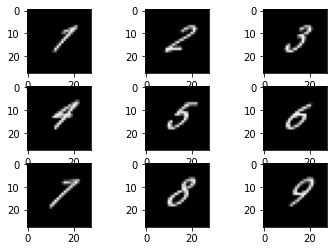

In [6]:
j=0
for i in range(211,220):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(train_per_x[i], cmap=plt.get_cmap('gray'))
  print (train_per_y[i], end =" ")
plt.show()

Reshape datasets to prepare for the model

In [7]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

train_per_x = train_per_x.reshape((train_per_x.shape[0], 28, 28, 1))
test_per_x = test_per_x.reshape((test_per_x.shape[0], 28, 28, 1))

Convert the label datasets to categorical since there are 10 possible target categories of digits:

In [8]:
# one hot encode target values
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

train_per_y = tf.keras.utils.to_categorical(train_per_y)
test_per_y = tf.keras.utils.to_categorical(test_per_y)

Convert the datasets of images from 8-bit grayscale pixels values to float values and normalize the values to range of 0 and 1:

In [9]:
# convert from integers to floats
trainX = trainX.astype('float32')
test_X = testX.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

# convert from integers to floats
train_per_x = train_per_x.astype('float32')
test_per_x = test_per_x.astype('float32')
# normalize to range 0-1
train_per_x = train_per_x / 255.0
test_per_x = test_per_x / 255.0

The function to creat a model. Here we are using a dense relu based model with Adam optimizer and default learning rate of 0.01.

In [10]:
# define model
def define_model():
  model = Sequential()
  model.add(Flatten())
  #model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = Adam(0.01)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

The function to run the model on given dataset and parameters using k-fold cross-validation:

In [11]:
# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds, n_epochs, n_batch_size):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

Creating the base random intitialized model and save it to reuse for the baseline. We want to use same random weights for comparing different methods fairly:

In [12]:
model = define_model()
model.build((None, 28, 28, 1))
model.save("random_init")

INFO:tensorflow:Assets written to: random_init/assets


Verifying the model layers, number of nodes, and parameters:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Function for visualizing model training performance: 

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
      # plot loss
      plt.subplot(2, 2, 1)
      plt.title('Cross Entropy Loss')
      plt.plot(histories[i].history['loss'], color='blue', label='train')
      plt.plot(histories[i].history['val_loss'], color='orange', label='test')
      # plot accuracy
      plt.subplot(2, 2, 2)
      plt.title('Classification Accuracy')
      plt.plot(histories[i].history['accuracy'], color='blue', label='train')
      plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

Creating a list to save each run performance on perfect train set, perfect test set, MNIST train set, MNIST test set

In [15]:
results = ([])

Saving the results of randomly initialized model with no training:

In [16]:
desc = "Random initialized with no training"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

['Random initialized with no training', 9.375, 10.0, 8.115, 7.77]


Training random intialized model on MNIST with different learning rates: 

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 1.6007 - accuracy: 0.6402 - val_loss: 0.9431 - val_accuracy: 0.6408
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.8265 - accuracy: 0.7062 - val_loss: 0.7672 - val_accuracy: 0.7383
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.7545 - accuracy: 0.7344 - val_loss: 0.7059 - val_accuracy: 0.7530
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.6978 - accuracy: 0.7546 - val_loss: 0.6937 - val_accuracy: 0.7593
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.7530 - accuracy: 0.7355 - val_loss: 0.7594 - val_accuracy: 0.7372
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.9143 - accuracy: 0.6872 - val_loss: 1.0544 - val_accuracy: 0.6002
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 1.1182 - accuracy: 0.5593 - val_loss: 1.1546 - val_accuracy: 0.5278
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


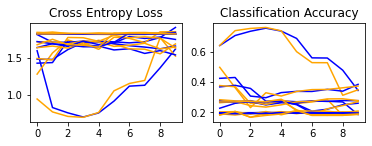

Accuracy: mean=24.527 std=6.608, n=10


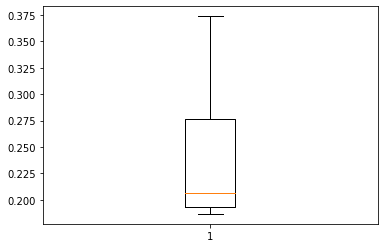

['Random initialized on MNIST with LR=0.1 & epoch=10', 15.0, 20.0, 19.27, 19.39]


In [17]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.1)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.1 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
375/375 [==============================] - 4s 10ms/step - loss: 0.2601 - accuracy: 0.9212 - val_loss: 0.1520 - val_accuracy: 0.9537
Epoch 2/8
375/375 [==============================] - 3s 9ms/step - loss: 0.1198 - accuracy: 0.9640 - val_loss: 0.1298 - val_accuracy: 0.9633
Epoch 3/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0991 - accuracy: 0.9701 - val_loss: 0.1464 - val_accuracy: 0.9622
Epoch 4/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0885 - accuracy: 0.9738 - val_loss: 0.1204 - val_accuracy: 0.9658
Epoch 5/8
375/375 [==============================] - 3s 9ms/step - loss: 0.0739 - accuracy: 0.9776 - val_loss: 0.1487 - val_accuracy: 0.9637
Epoch 6/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0780 - accuracy: 0.9764 - val_loss: 0.1586 - val_accuracy: 0.9630
Epoch 7/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0659 - accuracy: 0.9804 - val_loss: 0.1447 - val_accuracy: 0.9645
Epoch 8/8
18

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


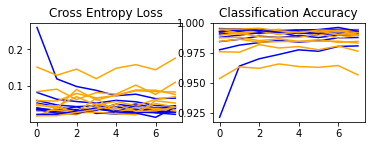

Accuracy: mean=98.517 std=1.081, n=10


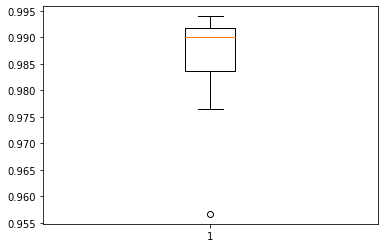

['Random initialized on MNIST with LR=0.01 & epoch=8', 47.5, 60.0, 99.34, 97.33]


In [41]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, trainX, trainy,10,8,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.01 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 0.2601 - accuracy: 0.9212 - val_loss: 0.1520 - val_accuracy: 0.9537
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1198 - accuracy: 0.9640 - val_loss: 0.1298 - val_accuracy: 0.9633
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0991 - accuracy: 0.9701 - val_loss: 0.1464 - val_accuracy: 0.9622
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0885 - accuracy: 0.9738 - val_loss: 0.1204 - val_accuracy: 0.9658
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0739 - accuracy: 0.9776 - val_loss: 0.1487 - val_accuracy: 0.9637
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0780 - accuracy: 0.9764 - val_loss: 0.1586 - val_accuracy: 0.9630
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0659 - accuracy: 0.9804 - val_loss: 0.1447 - val_accuracy: 0.9645
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


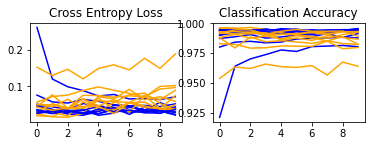

Accuracy: mean=98.550 std=0.858, n=10


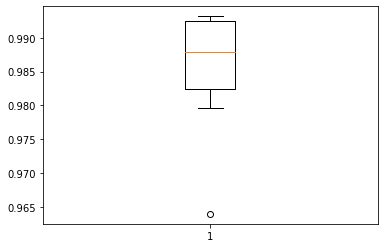

['Random initialized on MNIST with LR=0.01 & epoch=10', 51.25, 70.0, 99.283, 97.14]


In [19]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.01 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
375/375 [==============================] - 4s 9ms/step - loss: 0.3007 - accuracy: 0.9131 - val_loss: 0.1589 - val_accuracy: 0.9523
Epoch 2/8
375/375 [==============================] - 3s 8ms/step - loss: 0.1114 - accuracy: 0.9661 - val_loss: 0.1195 - val_accuracy: 0.9655
Epoch 3/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0716 - accuracy: 0.9784 - val_loss: 0.0939 - val_accuracy: 0.9728
Epoch 4/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0861 - val_accuracy: 0.9762
Epoch 5/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0823 - val_accuracy: 0.9757
Epoch 6/8
375/375 [==============================] - 3s 8ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.0982 - val_accuracy: 0.9738
Epoch 7/8
375/375 [==============================] - 3s 9ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0930 - val_accuracy: 0.9723
Epoch 8/8
188

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


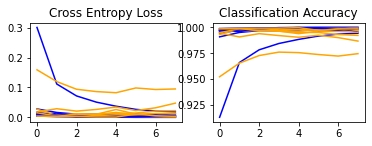

Accuracy: mean=99.407 std=0.748, n=10


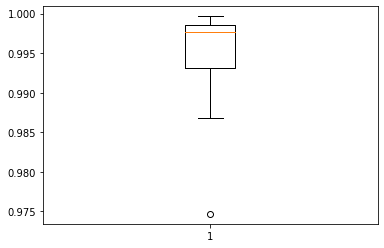

['Random initialized on MNIST with LR=0.001 & epoch=8', 58.125, 80.0, 99.945, 98.07]


In [20]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,8,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3007 - accuracy: 0.9131 - val_loss: 0.1589 - val_accuracy: 0.9523
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1114 - accuracy: 0.9661 - val_loss: 0.1195 - val_accuracy: 0.9655
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0716 - accuracy: 0.9784 - val_loss: 0.0939 - val_accuracy: 0.9728
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0861 - val_accuracy: 0.9762
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0823 - val_accuracy: 0.9757
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.0982 - val_accuracy: 0.9738
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0930 - val_accuracy: 0.9723
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


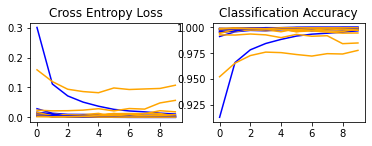

Accuracy: mean=99.487 std=0.706, n=10


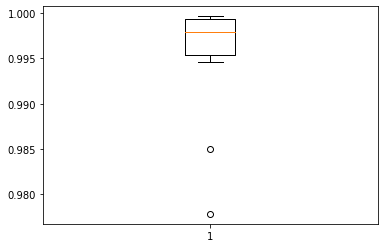

['Random initialized on MNIST with LR=0.001 & epoch=10', 56.875, 80.0, 99.997, 98.44]


In [21]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
375/375 [==============================] - 4s 8ms/step - loss: 0.8406 - accuracy: 0.7816 - val_loss: 0.3614 - val_accuracy: 0.9043
Epoch 2/8
375/375 [==============================] - 3s 8ms/step - loss: 0.2989 - accuracy: 0.9182 - val_loss: 0.2687 - val_accuracy: 0.9272
Epoch 3/8
375/375 [==============================] - 3s 8ms/step - loss: 0.2325 - accuracy: 0.9359 - val_loss: 0.2256 - val_accuracy: 0.9380
Epoch 4/8
375/375 [==============================] - 3s 8ms/step - loss: 0.1961 - accuracy: 0.9454 - val_loss: 0.1975 - val_accuracy: 0.9452
Epoch 5/8
375/375 [==============================] - 3s 7ms/step - loss: 0.1698 - accuracy: 0.9524 - val_loss: 0.1827 - val_accuracy: 0.9507
Epoch 6/8
375/375 [==============================] - 3s 7ms/step - loss: 0.1499 - accuracy: 0.9578 - val_loss: 0.1725 - val_accuracy: 0.9490
Epoch 7/8
375/375 [==============================] - 3s 8ms/step - loss: 0.1337 - accuracy: 0.9624 - val_loss: 0.1557 - val_accuracy: 0.9560
Epoch 8/8
188

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


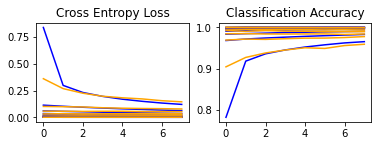

Accuracy: mean=98.995 std=1.247, n=10


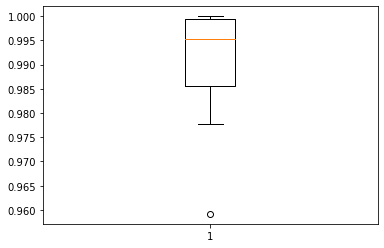

['Random initialized on MNIST with LR=0.0001 & epoch=8', 51.25, 60.0, 100.0, 98.1]


In [22]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,8,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.0001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
375/375 [==============================] - 3s 8ms/step - loss: 0.8406 - accuracy: 0.7816 - val_loss: 0.3614 - val_accuracy: 0.9043
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.2989 - accuracy: 0.9182 - val_loss: 0.2687 - val_accuracy: 0.9272
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.2325 - accuracy: 0.9359 - val_loss: 0.2256 - val_accuracy: 0.9380
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1961 - accuracy: 0.9454 - val_loss: 0.1975 - val_accuracy: 0.9452
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1698 - accuracy: 0.9524 - val_loss: 0.1827 - val_accuracy: 0.9507
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1499 - accuracy: 0.9578 - val_loss: 0.1725 - val_accuracy: 0.9490
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1337 - accuracy: 0.9624 - val_loss: 0.1557 - val_accuracy: 0.9560
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


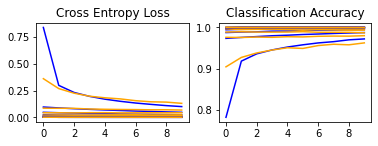

Accuracy: mean=99.172 std=1.161, n=10


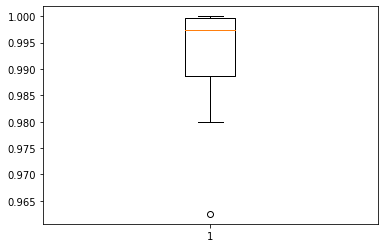

['Random initialized on MNIST with LR=0.0001 & epoch=10', 54.375, 65.0, 100.0, 98.14]


In [23]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.0001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Training random intialized model on perfect training set with different learning rates:

Epoch 1/24
2/2 [==============================] - 1s 196ms/step - loss: 31.3733 - accuracy: 0.1389 - val_loss: 51.5913 - val_accuracy: 0.0625
Epoch 2/24
2/2 [==============================] - 0s 36ms/step - loss: 35.4790 - accuracy: 0.1007 - val_loss: 7.7345 - val_accuracy: 0.0938
Epoch 3/24
2/2 [==============================] - 0s 42ms/step - loss: 5.5414 - accuracy: 0.1736 - val_loss: 2.2165 - val_accuracy: 0.2812
Epoch 4/24
2/2 [==============================] - 0s 36ms/step - loss: 2.1291 - accuracy: 0.2257 - val_loss: 2.0967 - val_accuracy: 0.1875
Epoch 5/24
2/2 [==============================] - 0s 37ms/step - loss: 1.9917 - accuracy: 0.2292 - val_loss: 1.9680 - val_accuracy: 0.1875
Epoch 6/24
2/2 [==============================] - 0s 41ms/step - loss: 1.8806 - accuracy: 0.2847 - val_loss: 1.8722 - val_accuracy: 0.3438
Epoch 7/24
2/2 [==============================] - 0s 34ms/step - loss: 1.9432 - accuracy: 0.3125 - val_loss: 1.7460 - val_accuracy: 0.3438
Epoch 8/24
2/2 [=======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


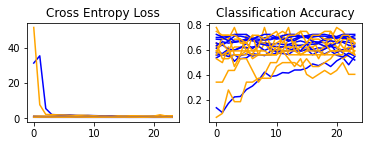

Accuracy: mean=60.000 std=7.629, n=10


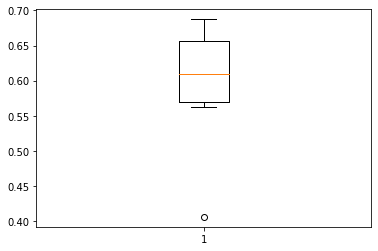

['Random initialized on perfect data with LR=0.1 & epoch=24', 70.0, 65.0, 23.392, 24.64]


In [24]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.1)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.1 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/24
2/2 [==============================] - 1s 198ms/step - loss: 7.3456 - accuracy: 0.1285 - val_loss: 12.7828 - val_accuracy: 0.1562
Epoch 2/24
2/2 [==============================] - 0s 35ms/step - loss: 11.0855 - accuracy: 0.1319 - val_loss: 5.7275 - val_accuracy: 0.0625
Epoch 3/24
2/2 [==============================] - 0s 36ms/step - loss: 4.1791 - accuracy: 0.1215 - val_loss: 2.2363 - val_accuracy: 0.2188
Epoch 4/24
2/2 [==============================] - 0s 38ms/step - loss: 1.9966 - accuracy: 0.3438 - val_loss: 1.5036 - val_accuracy: 0.4688
Epoch 5/24
2/2 [==============================] - 0s 35ms/step - loss: 1.3783 - accuracy: 0.5104 - val_loss: 1.1174 - val_accuracy: 0.5625
Epoch 6/24
2/2 [==============================] - 0s 35ms/step - loss: 1.0645 - accuracy: 0.6285 - val_loss: 0.7712 - val_accuracy: 0.7188
Epoch 7/24
2/2 [==============================] - 0s 37ms/step - loss: 0.7495 - accuracy: 0.7431 - val_loss: 0.5850 - val_accuracy: 0.8125
Epoch 8/24
2/2 [========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


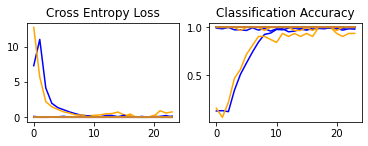

Accuracy: mean=99.375 std=1.875, n=10


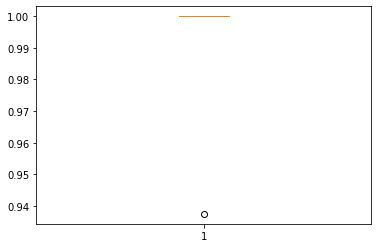

['Random initialized on perfect data with LR=0.05 & epoch=24', 100.0, 95.0, 27.14, 27.61]


In [25]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.05)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.05")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.05 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/24
2/2 [==============================] - 1s 189ms/step - loss: 2.3391 - accuracy: 0.1285 - val_loss: 2.1630 - val_accuracy: 0.3750
Epoch 2/24
2/2 [==============================] - 0s 37ms/step - loss: 1.7441 - accuracy: 0.5174 - val_loss: 1.1075 - val_accuracy: 0.8125
Epoch 3/24
2/2 [==============================] - 0s 40ms/step - loss: 0.9438 - accuracy: 0.7778 - val_loss: 0.6082 - val_accuracy: 0.8125
Epoch 4/24
2/2 [==============================] - 0s 35ms/step - loss: 0.5267 - accuracy: 0.8438 - val_loss: 0.4241 - val_accuracy: 0.8125
Epoch 5/24
2/2 [==============================] - 0s 44ms/step - loss: 0.2869 - accuracy: 0.9271 - val_loss: 0.3546 - val_accuracy: 0.8750
Epoch 6/24
2/2 [==============================] - 0s 34ms/step - loss: 0.1090 - accuracy: 0.9792 - val_loss: 0.2642 - val_accuracy: 0.9062
Epoch 7/24
2/2 [==============================] - 0s 35ms/step - loss: 0.0620 - accuracy: 0.9965 - val_loss: 0.2707 - val_accuracy: 0.9062
Epoch 8/24
2/2 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


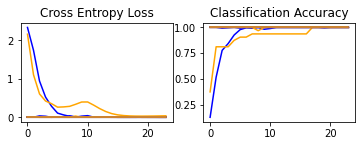

Accuracy: mean=100.000 std=0.000, n=10


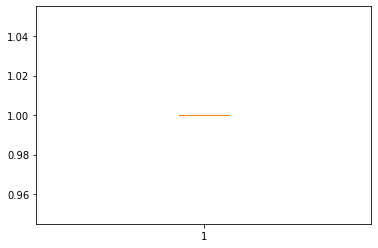

['Random initialized on perfect data with LR=0.01 & epoch=24', 100.0, 100.0, 34.775, 36.38]


In [26]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.01")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.01 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/24
2/2 [==============================] - 1s 193ms/step - loss: 2.2613 - accuracy: 0.1424 - val_loss: 1.8699 - val_accuracy: 0.5000
Epoch 2/24
2/2 [==============================] - 0s 33ms/step - loss: 1.6515 - accuracy: 0.6458 - val_loss: 1.2425 - val_accuracy: 0.6875
Epoch 3/24
2/2 [==============================] - 0s 34ms/step - loss: 1.0633 - accuracy: 0.7465 - val_loss: 0.7805 - val_accuracy: 0.8438
Epoch 4/24
2/2 [==============================] - 0s 37ms/step - loss: 0.6515 - accuracy: 0.8472 - val_loss: 0.4709 - val_accuracy: 0.8750
Epoch 5/24
2/2 [==============================] - 0s 36ms/step - loss: 0.3866 - accuracy: 0.9236 - val_loss: 0.3796 - val_accuracy: 0.9062
Epoch 6/24
2/2 [==============================] - 0s 37ms/step - loss: 0.2042 - accuracy: 0.9757 - val_loss: 0.3042 - val_accuracy: 0.8750
Epoch 7/24
2/2 [==============================] - 0s 32ms/step - loss: 0.1251 - accuracy: 0.9826 - val_loss: 0.1864 - val_accuracy: 0.9062
Epoch 8/24
2/2 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


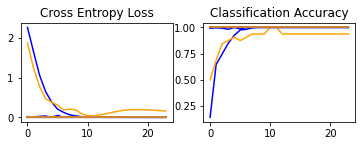

Accuracy: mean=99.375 std=1.875, n=10


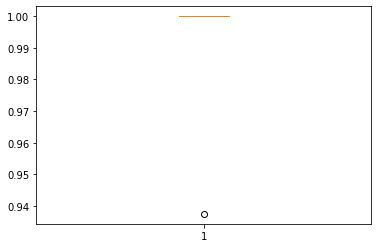

['Random initialized on perfect data with LR=0.005 & epoch=24', 100.0, 95.0, 37.36, 38.76]


In [27]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.005)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.005")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.005 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/24
2/2 [==============================] - 1s 191ms/step - loss: 2.2941 - accuracy: 0.1111 - val_loss: 2.1359 - val_accuracy: 0.2500
Epoch 2/24
2/2 [==============================] - 0s 37ms/step - loss: 2.0827 - accuracy: 0.3993 - val_loss: 1.9912 - val_accuracy: 0.5312
Epoch 3/24
2/2 [==============================] - 0s 39ms/step - loss: 1.9122 - accuracy: 0.6458 - val_loss: 1.8450 - val_accuracy: 0.6562
Epoch 4/24
2/2 [==============================] - 0s 35ms/step - loss: 1.7457 - accuracy: 0.7674 - val_loss: 1.6906 - val_accuracy: 0.7812
Epoch 5/24
2/2 [==============================] - 0s 37ms/step - loss: 1.5793 - accuracy: 0.8299 - val_loss: 1.5369 - val_accuracy: 0.7812
Epoch 6/24
2/2 [==============================] - 0s 39ms/step - loss: 1.4103 - accuracy: 0.8507 - val_loss: 1.3772 - val_accuracy: 0.8125
Epoch 7/24
2/2 [==============================] - 0s 41ms/step - loss: 1.2463 - accuracy: 0.8438 - val_loss: 1.2183 - val_accuracy: 0.7812
Epoch 8/24
2/2 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


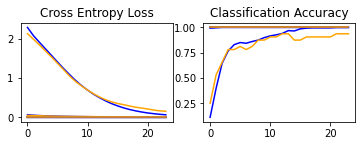

Accuracy: mean=99.375 std=1.875, n=10


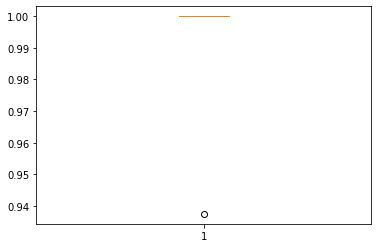

['Random initialized on perfect data with LR=0.001 & epoch=24', 100.0, 95.0, 36.238, 37.76]


In [28]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.001")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.001 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/24
2/2 [==============================] - 1s 193ms/step - loss: 2.3286 - accuracy: 0.0903 - val_loss: 2.3045 - val_accuracy: 0.0938
Epoch 2/24
2/2 [==============================] - 0s 34ms/step - loss: 2.3006 - accuracy: 0.0868 - val_loss: 2.2818 - val_accuracy: 0.0938
Epoch 3/24
2/2 [==============================] - 0s 39ms/step - loss: 2.2742 - accuracy: 0.1042 - val_loss: 2.2605 - val_accuracy: 0.0938
Epoch 4/24
2/2 [==============================] - 0s 33ms/step - loss: 2.2500 - accuracy: 0.1285 - val_loss: 2.2404 - val_accuracy: 0.0625
Epoch 5/24
2/2 [==============================] - 0s 32ms/step - loss: 2.2265 - accuracy: 0.1389 - val_loss: 2.2216 - val_accuracy: 0.0938
Epoch 6/24
2/2 [==============================] - 0s 37ms/step - loss: 2.2045 - accuracy: 0.1806 - val_loss: 2.2036 - val_accuracy: 0.0938
Epoch 7/24
2/2 [==============================] - 0s 34ms/step - loss: 2.1829 - accuracy: 0.2292 - val_loss: 2.1862 - val_accuracy: 0.0938
Epoch 8/24
2/2 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


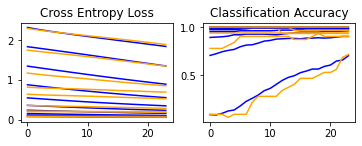

Accuracy: mean=94.688 std=8.274, n=10


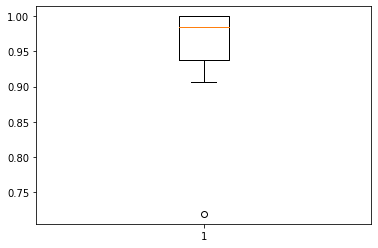

['Random initialized on perfect data with LR=0.0001 & epoch=24', 100.0, 95.0, 35.907, 37.49]


In [29]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,24,144)

model.save("trained_perfect_0.0001")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.0001 & epoch=24"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Finetune a trained model with perfect data on MNIST

Epoch 1/8
375/375 [==============================] - 3s 8ms/step - loss: 4.3990 - accuracy: 0.5539 - val_loss: 1.3995 - val_accuracy: 0.7073
Epoch 2/8
375/375 [==============================] - 3s 8ms/step - loss: 0.8797 - accuracy: 0.7773 - val_loss: 0.5947 - val_accuracy: 0.8273
Epoch 3/8
375/375 [==============================] - 3s 7ms/step - loss: 0.4778 - accuracy: 0.8614 - val_loss: 0.4050 - val_accuracy: 0.8797
Epoch 4/8
375/375 [==============================] - 3s 8ms/step - loss: 0.3497 - accuracy: 0.8965 - val_loss: 0.3204 - val_accuracy: 0.9067
Epoch 5/8
375/375 [==============================] - 3s 7ms/step - loss: 0.2821 - accuracy: 0.9171 - val_loss: 0.2718 - val_accuracy: 0.9212
Epoch 6/8
375/375 [==============================] - 3s 8ms/step - loss: 0.2388 - accuracy: 0.9293 - val_loss: 0.2396 - val_accuracy: 0.9322
Epoch 7/8
375/375 [==============================] - 3s 8ms/step - loss: 0.2076 - accuracy: 0.9387 - val_loss: 0.2153 - val_accuracy: 0.9378
Epoch 8/8
188

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


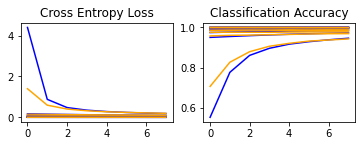

Accuracy: mean=98.592 std=1.732, n=10


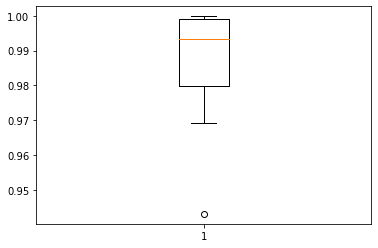

['Finetune on MNIST with LR=0.0001 & epoch=8', 79.375, 85.0, 99.998, 98.0]


In [30]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,8,144)

model.save("finetuned_1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.0001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 4.3990 - accuracy: 0.5539 - val_loss: 1.3995 - val_accuracy: 0.7073
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.8797 - accuracy: 0.7773 - val_loss: 0.5947 - val_accuracy: 0.8273
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.4778 - accuracy: 0.8614 - val_loss: 0.4050 - val_accuracy: 0.8797
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.3497 - accuracy: 0.8965 - val_loss: 0.3204 - val_accuracy: 0.9067
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.2821 - accuracy: 0.9171 - val_loss: 0.2718 - val_accuracy: 0.9212
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.2388 - accuracy: 0.9293 - val_loss: 0.2396 - val_accuracy: 0.9322
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.2076 - accuracy: 0.9387 - val_loss: 0.2153 - val_accuracy: 0.9378
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


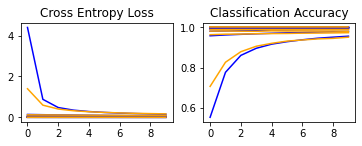

Accuracy: mean=98.898 std=1.510, n=10


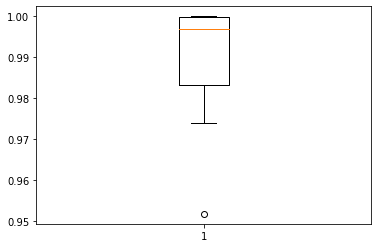

['Finetune on MNIST with LR=0.0001 & epoch=10', 79.375, 85.0, 100.0, 98.08]


In [31]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

model.save("finetuned_2")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.0001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
375/375 [==============================] - 3s 8ms/step - loss: 10.5216 - accuracy: 0.3777 - val_loss: 8.9545 - val_accuracy: 0.4063
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 7.9760 - accuracy: 0.4228 - val_loss: 6.8730 - val_accuracy: 0.4472
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 6.1605 - accuracy: 0.4639 - val_loss: 5.3340 - val_accuracy: 0.4907
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 4.7872 - accuracy: 0.5047 - val_loss: 4.1693 - val_accuracy: 0.5340
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 3.7443 - accuracy: 0.5461 - val_loss: 3.2899 - val_accuracy: 0.5773
Epoch 6/10
375/375 [==============================] - 3s 7ms/step - loss: 2.9620 - accuracy: 0.5869 - val_loss: 2.6335 - val_accuracy: 0.6113
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 2.3818 - accuracy: 0.6247 - val_loss: 2.1447 - val_accuracy: 0.6432
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


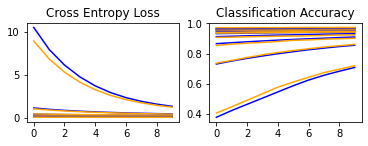

Accuracy: mean=91.555 std=7.294, n=10


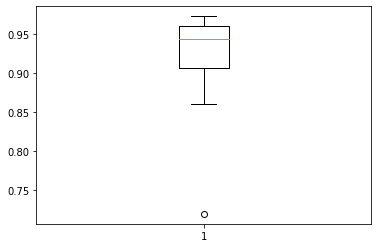

['Finetune on MNIST with LR=0.00001 & epoch=10', 88.125, 90.0, 97.085, 96.44]


In [32]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,10,144)

model.save("finetuned_3")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.00001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Fine tune on the mix of perfect data and MNIST:

In [40]:
trainmixX = np. concatenate((trainX, train_per_x), axis=0)
trainmixy = np. concatenate((trainy, train_per_y), axis=0)
print(trainmixX.shape)
print(trainmixy.shape)

(60320, 28, 28, 1)
(60320, 10)


Epoch 1/8
377/377 [==============================] - 4s 9ms/step - loss: 4.4087 - accuracy: 0.5545 - val_loss: 1.3851 - val_accuracy: 0.7102
Epoch 2/8
377/377 [==============================] - 3s 8ms/step - loss: 0.8821 - accuracy: 0.7781 - val_loss: 0.5825 - val_accuracy: 0.8309
Epoch 3/8
377/377 [==============================] - 3s 8ms/step - loss: 0.4770 - accuracy: 0.8610 - val_loss: 0.3994 - val_accuracy: 0.8803
Epoch 4/8
377/377 [==============================] - 3s 8ms/step - loss: 0.3499 - accuracy: 0.8965 - val_loss: 0.3156 - val_accuracy: 0.9053
Epoch 5/8
377/377 [==============================] - 3s 8ms/step - loss: 0.2829 - accuracy: 0.9170 - val_loss: 0.2666 - val_accuracy: 0.9216
Epoch 6/8
377/377 [==============================] - 3s 7ms/step - loss: 0.2398 - accuracy: 0.9302 - val_loss: 0.2356 - val_accuracy: 0.9300
Epoch 7/8
377/377 [==============================] - 3s 7ms/step - loss: 0.2087 - accuracy: 0.9392 - val_loss: 0.2120 - val_accuracy: 0.9350
Epoch 8/8
189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


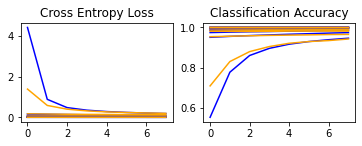

Accuracy: mean=98.617 std=1.772, n=10


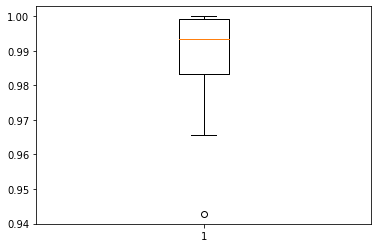

['Finetune on Mix data with LR=0.0001 & epoch=8', 100.0, 95.0, 100.0, 98.02]


In [34]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,8,144)

model.save("finetuned_4")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.0001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
377/377 [==============================] - 4s 8ms/step - loss: 4.4087 - accuracy: 0.5545 - val_loss: 1.3851 - val_accuracy: 0.7102
Epoch 2/10
377/377 [==============================] - 3s 8ms/step - loss: 0.8821 - accuracy: 0.7781 - val_loss: 0.5825 - val_accuracy: 0.8309
Epoch 3/10
377/377 [==============================] - 3s 8ms/step - loss: 0.4770 - accuracy: 0.8610 - val_loss: 0.3994 - val_accuracy: 0.8803
Epoch 4/10
377/377 [==============================] - 3s 8ms/step - loss: 0.3499 - accuracy: 0.8965 - val_loss: 0.3156 - val_accuracy: 0.9053
Epoch 5/10
377/377 [==============================] - 3s 8ms/step - loss: 0.2829 - accuracy: 0.9170 - val_loss: 0.2666 - val_accuracy: 0.9216
Epoch 6/10
377/377 [==============================] - 3s 8ms/step - loss: 0.2398 - accuracy: 0.9302 - val_loss: 0.2356 - val_accuracy: 0.9300
Epoch 7/10
377/377 [==============================] - 3s 8ms/step - loss: 0.2087 - accuracy: 0.9392 - val_loss: 0.2120 - val_accuracy: 0.9350
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


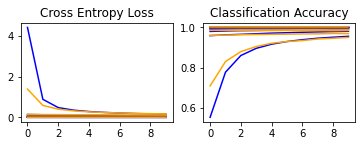

Accuracy: mean=98.881 std=1.569, n=10


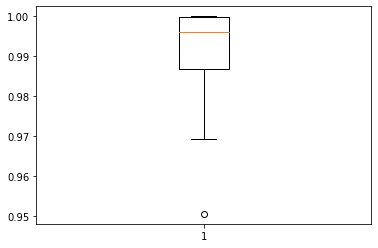

['Finetune on Mix data with LR=0.0001 & epoch=10', 100.0, 100.0, 100.0, 98.05]


In [35]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,10,144)

model.save("finetuned_5")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.0001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/14
377/377 [==============================] - 4s 9ms/step - loss: 10.4989 - accuracy: 0.3795 - val_loss: 8.6811 - val_accuracy: 0.4203
Epoch 2/14
377/377 [==============================] - 3s 8ms/step - loss: 7.9419 - accuracy: 0.4259 - val_loss: 6.7017 - val_accuracy: 0.4571
Epoch 3/14
377/377 [==============================] - 3s 9ms/step - loss: 6.1239 - accuracy: 0.4669 - val_loss: 5.2205 - val_accuracy: 0.4987
Epoch 4/14
377/377 [==============================] - 3s 8ms/step - loss: 4.7541 - accuracy: 0.5087 - val_loss: 4.0896 - val_accuracy: 0.5390
Epoch 5/14
377/377 [==============================] - 3s 8ms/step - loss: 3.7163 - accuracy: 0.5502 - val_loss: 3.2293 - val_accuracy: 0.5756
Epoch 6/14
377/377 [==============================] - 3s 8ms/step - loss: 2.9387 - accuracy: 0.5909 - val_loss: 2.5855 - val_accuracy: 0.6146
Epoch 7/14
377/377 [==============================] - 3s 8ms/step - loss: 2.3628 - accuracy: 0.6272 - val_loss: 2.1040 - val_accuracy: 0.6485
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


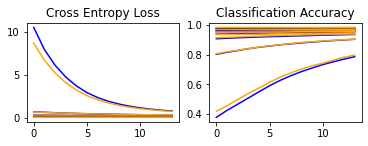

Accuracy: mean=93.936 std=5.219, n=10


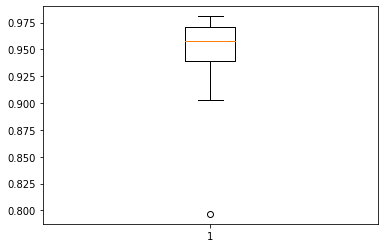

['Finetune on Mix data with LR=0.00001 & epoch=14', 97.5, 95.0, 98.012, 96.95]


In [48]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,14,144)

model.save("finetuned_6")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.00001 & epoch=14"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/10
377/377 [==============================] - 4s 9ms/step - loss: 0.7726 - accuracy: 0.8620 - val_loss: 0.1861 - val_accuracy: 0.9450
Epoch 2/10
377/377 [==============================] - 3s 8ms/step - loss: 0.1387 - accuracy: 0.9586 - val_loss: 0.1304 - val_accuracy: 0.9619
Epoch 3/10
377/377 [==============================] - 3s 8ms/step - loss: 0.0911 - accuracy: 0.9725 - val_loss: 0.1091 - val_accuracy: 0.9678
Epoch 4/10
377/377 [==============================] - 3s 8ms/step - loss: 0.0644 - accuracy: 0.9810 - val_loss: 0.0959 - val_accuracy: 0.9720
Epoch 5/10
377/377 [==============================] - 3s 8ms/step - loss: 0.0472 - accuracy: 0.9862 - val_loss: 0.0861 - val_accuracy: 0.9731
Epoch 6/10
377/377 [==============================] - 3s 8ms/step - loss: 0.0343 - accuracy: 0.9903 - val_loss: 0.0850 - val_accuracy: 0.9755
Epoch 7/10
377/377 [==============================] - 3s 8ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.0805 - val_accuracy: 0.9776
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


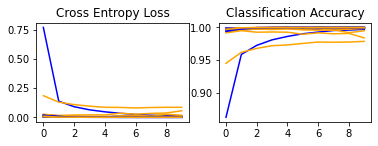

Accuracy: mean=99.537 std=0.730, n=10


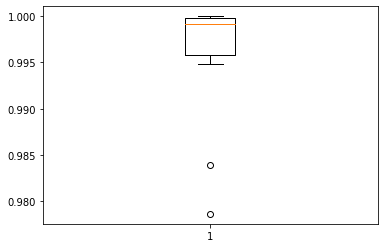

['Finetune on Mix data with LR=0.001 & epoch=10', 100.0, 95.0, 100.0, 98.38]


In [53]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,10,144)

model.save("finetuned_7")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.001 & epoch=10"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
377/377 [==============================] - 4s 9ms/step - loss: 0.7726 - accuracy: 0.8620 - val_loss: 0.1861 - val_accuracy: 0.9450
Epoch 2/8
377/377 [==============================] - 3s 8ms/step - loss: 0.1387 - accuracy: 0.9586 - val_loss: 0.1304 - val_accuracy: 0.9619
Epoch 3/8
377/377 [==============================] - 3s 8ms/step - loss: 0.0911 - accuracy: 0.9725 - val_loss: 0.1091 - val_accuracy: 0.9678
Epoch 4/8
377/377 [==============================] - 3s 8ms/step - loss: 0.0644 - accuracy: 0.9810 - val_loss: 0.0959 - val_accuracy: 0.9720
Epoch 5/8
377/377 [==============================] - 3s 8ms/step - loss: 0.0472 - accuracy: 0.9862 - val_loss: 0.0861 - val_accuracy: 0.9731
Epoch 6/8
377/377 [==============================] - 3s 8ms/step - loss: 0.0343 - accuracy: 0.9903 - val_loss: 0.0850 - val_accuracy: 0.9755
Epoch 7/8
377/377 [==============================] - 3s 8ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.0805 - val_accuracy: 0.9776
Epoch 8/8
189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


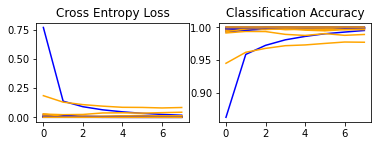

Accuracy: mean=99.542 std=0.674, n=10


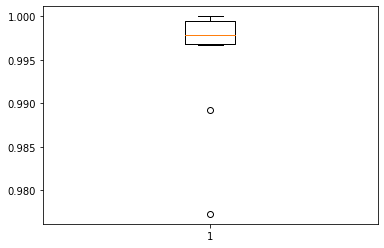

['Finetune on Mix data with LR=0.001 & epoch=8', 100.0, 95.0, 100.0, 98.33]


In [56]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,8,144)

model.save("finetuned_8")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(test_per_x, test_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

In [57]:
results

[['Random initialized with no training', 9.375, 10.0, 8.115, 7.77],
 ['Random initialized on MNIST with LR=0.1 & epoch=10',
  15.0,
  20.0,
  19.27,
  19.39],
 ['Random initialized on MNIST with LR=0.01 & epoch=8',
  47.5,
  60.0,
  99.34,
  97.33],
 ['Random initialized on MNIST with LR=0.01 & epoch=10',
  51.25,
  70.0,
  99.283,
  97.14],
 ['Random initialized on MNIST with LR=0.001 & epoch=8',
  58.125,
  80.0,
  99.945,
  98.07],
 ['Random initialized on MNIST with LR=0.001 & epoch=10',
  56.875,
  80.0,
  99.997,
  98.44],
 ['Random initialized on MNIST with LR=0.0001 & epoch=8',
  51.25,
  60.0,
  100.0,
  98.1],
 ['Random initialized on MNIST with LR=0.0001 & epoch=10',
  54.375,
  65.0,
  100.0,
  98.14],
 ['Random initialized on perfect data with LR=0.1 & epoch=24',
  70.0,
  65.0,
  23.392,
  24.64],
 ['Random initialized on perfect data with LR=0.05 & epoch=24',
  100.0,
  95.0,
  27.14,
  27.61],
 ['Random initialized on perfect data with LR=0.01 & epoch=24',
  100.0,
  10

In [58]:
import pandas
df=pandas.DataFrame(results,list(range(1, len(results)+1)),["Description","Train perfect", "Test perfect", "Train MNIST", "Test MNIST"])
df

,Description,Train perfect,Test perfect,Train MNIST,Test MNIST
1,Random initialized with no training,9.375,10.0,8.115,7.77
2,Random initialized on MNIST with LR=0.1 & epoc...,15.000,20.0,19.270,19.39
3,Random initialized on MNIST with LR=0.01 & epo...,47.500,60.0,99.340,97.33
4,Random initialized on MNIST with LR=0.01 & epo...,51.250,70.0,99.283,97.14
5,Random initialized on MNIST with LR=0.001 & ep...,58.125,80.0,99.945,98.07
6,Random initialized on MNIST with LR=0.001 & ep...,56.875,80.0,99.997,98.44
7,Random initialized on MNIST with LR=0.0001 & e...,51.250,60.0,100.000,98.10
8,Random initialized on MNIST with LR=0.0001 & e...,54.375,65.0,100.000,98.14
9,Random initialized on perfect data with LR=0.1...,70.000,65.0,23.392,24.64
10,Random initialized on perfect data with LR=0.0...,100.000,95.0,27.140,27.61


In [59]:
df.to_csv('results.txt', sep='\t', encoding='utf-8')

In [60]:
!zip -r /content/file.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.03.09/ (stored 0%)
  adding: content/.config/logs/2022.03.09/14.47.40.126263.log (deflated 86%)
  adding: content/.config/logs/2022.03.09/14.48.04.811374.log (deflated 55%)
  adding: content/.config/logs/2022.03.09/14.48.05.464073.log (deflated 54%)
  adding: content/.config/logs/2022.03.09/14.47.03.286667.log (deflated 91%)
  adding: content/.config/logs/2022.03.09/14.47.47.173052.log (deflated 53%)
  adding: content/.config/logs/2022.03.09/14.47.22.983659.log (deflated 54%)
  adding: 